<a href="https://colab.research.google.com/github/rouyu0405/NLP/blob/main/retrieval_augmented_generation__rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval-Augmented Generation (RAG)
## Introduction
Modern Large Language Models (LLMs), such as GPT, are incredibly powerful for generating coherent text. However, they have some limitations. Retrieval-Augmented Generation (RAG) addresses these limitations by combining retrieval of relevant information with language generation. This approach enables systems to provide accurate, context-aware responses by grounding their output in external knowledge sources.

## Real-World Applications of RAG
**Customer Support:** Providing answers using a company’s FAQs and support documents.

**Chatbots:** Enhancing conversational agents with domain-specific knowledge.

**Question Answering:** Answering user queries using the latest or external knowledge.

## Why Do We Need RAG?
While modern Large Language Models (LLMs), such as GPT, are powerful and capable of generating coherent text, they face some significant limitations:

1. **Knowledge Cutoff:** LLMs are trained on data up to a certain point in time and cannot access newer information after training.

2. **Hallucination:** LLMs may generate plausible-sounding responses that are factually incorrect or fabricated.

3. **Limited Domain Knowledge:** Without additional grounding, LLMs may fail to provide specific, accurate responses in specialized domains.


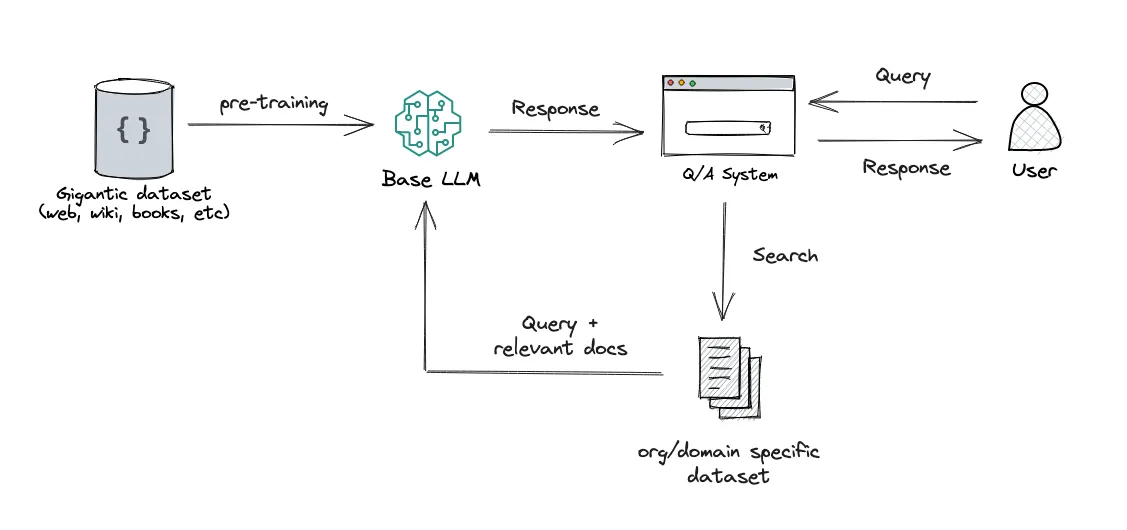


## How Does RAG Work?
RAG addresses these limitations by:

- **Retrieving Relevant Information:** From an external knowledge source (like a database or documents) based on the user's query.

- **Using the Retrieved Information:** As context to generate responses with an LLM.

This approach ensures that the responses are:

- **Grounded in factual data:** By relying on external documents.

- **Domain-specific:** By retrieving knowledge tailored to the query.

## Workflow of RAG
1. **Retriever:** Identifies the most relevant pieces of information for a given query from a knowledge base using dense embeddings or other search methods.

2. **Generator:** Combines the retrieved context with the query and generates a response using a language model.

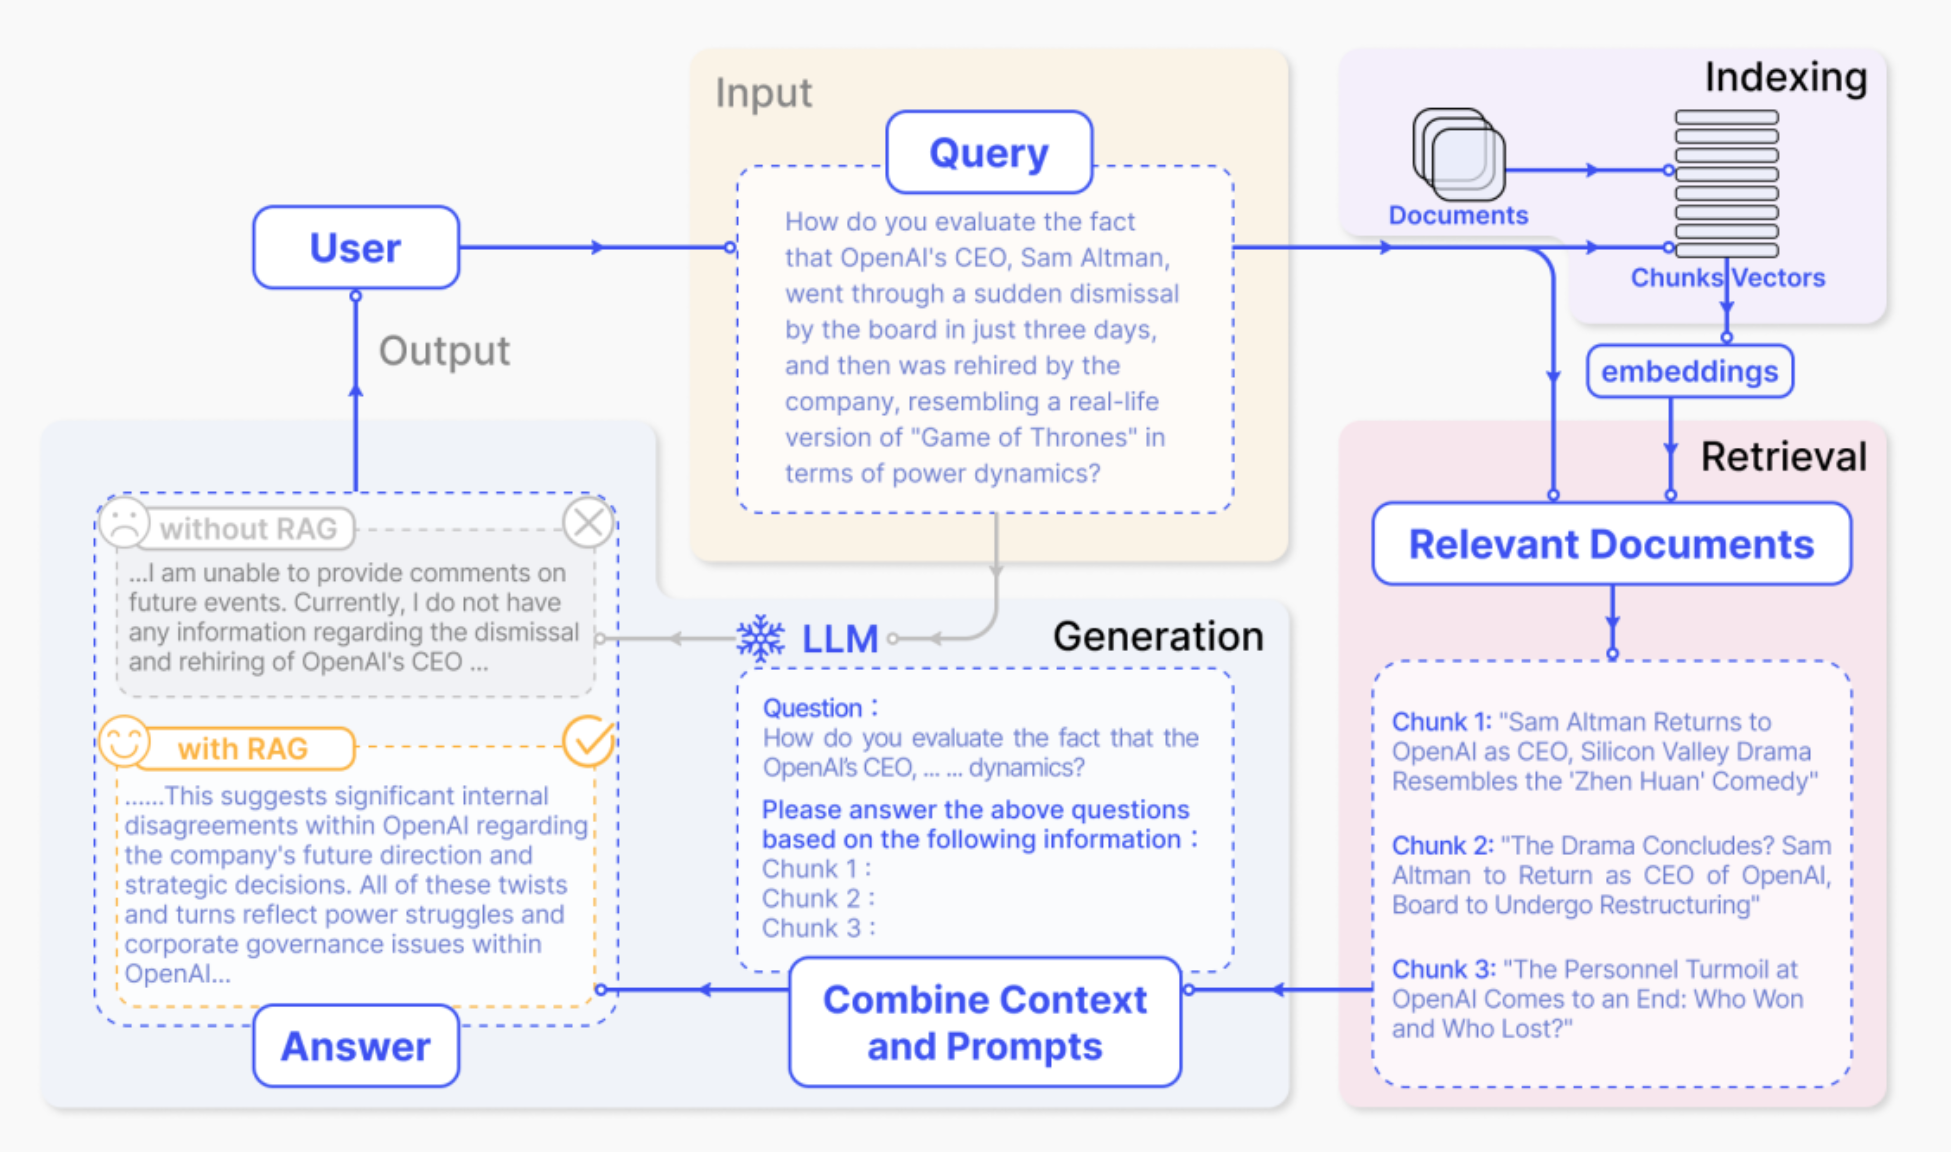

In this notebook, you will:

1. Learn the basic principles of RAG.
2. Ask an LLM a question without RAG to see how it responds with its pre-trained knowledge.
3. Build a simple indexing system to retrieve relevant information for a query.
4. Integrate retrieval and generation to produce better, grounded responses.
5. Compare responses generated with and without RAG to understand its benefits.





# Install Dependencies
Install libraries required for the project:

In [1]:
!pip install transformers sentence-transformers -q


# Import Necessary Libraries

In [2]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Step 1: Ask LLM Without RAG

In [3]:
# Load a pre-trained language model for text generation
llm = pipeline('text-generation', model='gpt2')  # A lightweight example for demonstration

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [4]:
# Ask the model a question
question = "What is RAG?"
response = llm(question, max_length=50, num_return_sequences=1)
print("Response from LLM without RAG:", response[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response from LLM without RAG: What is RAG? It's an acronym for Rate of Change in the United States, which is the percentage change in the actual rate of change in the world. It's a measure of how quickly a country is changing. One way to measure RAG is by how quickly a country has changed since its inception. It's what happens when the economy is stable or going to be stable. That means that the rate of change in the United States is less than 3 percent, but that's what you get for the rate of change in the world.

If we look at the world of the world, we see that the world's rate of change is about 4 percent. You can see that over the last half century, the world's rate of change has been about 2 percent. Today, the world's rate of change is about 10 percent. That's what you get for the rate of change in the United States.

The fact is, the rate of change has been declining in the United States for the last half century. In fact, the rate of change in the United States has been falli

# Step 2: Create a Simple Indexing System

In this step, we will create a **retrieval mechanism** to search for relevant information from a collection of documents. This is the foundation of the **Retriever** component in Retrieval-Augmented Generation (RAG). Here's how it works:

### **Why Do We Need an Indexing System?**
- **Efficiency**: Searching through an entire dataset every time a query is made can be computationally expensive. Indexing speeds up this process by organizing data for quick retrieval.
- **Relevance**: By creating a system that compares the query with the content of the documents, we can find the most relevant information.
- **Foundation of RAG**: The retrieved information from the index will be passed to the language model to generate grounded and specific responses.


### **What is an Index?**
An index is a data structure that allows for fast search and retrieval of information. In the context of RAG, **we use embeddings to represent the content of documents numerically**. This allows us to compute the **similarity** between a query and each document efficiently.

### **Steps to Build the Indexing System**
1. **Define a Knowledge Base (Corpus)**: This is the collection of documents or pieces of information that the system can retrieve.

2. **Generate Dense Embeddings**: Each document is converted into a dense vector representation using a **pre-trained embedding model** (e.g., SentenceTransformers). Dense embeddings capture the semantic meaning of the text, making it easier to find similar content.

3. **Create the Index**: Using pandas for indexing allows you to create a more human-readable representation of the documents and their embeddings, while still enabling retrieval.

4. **Retrieve Context**: When a query is provided, it is converted into an embedding using the same model. The index is queried to find the most relevant documents based on their similarity to the query.


## Prepare a Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
file_path = "/content/drive/MyDrive/360_Project/NLP_Dataset/labeled_lyrics_cleaned.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["Unnamed: 0"])
documents = df.astype(str).apply(lambda x: ' | '.join(x), axis=1).tolist()
df["Document"] = documents

print(df.head(2))
print(documents[:3])

         artist                                                seq  \
0  Elijah Blake  No, no\r\nI ain't ever trapped out the bando\r...   
1  Elijah Blake  The drinks go down and smoke goes up, I feel m...   

               song  label                                           Document  
0          Everyday  0.626  Elijah Blake | No, no\r\nI ain't ever trapped ...  
1  Live Till We Die  0.630  Elijah Blake | The drinks go down and smoke go...  
["Elijah Blake | No, no\r\nI ain't ever trapped out the bando\r\nBut oh Lord, don't get me wrong\r\nI know a couple niggas that do\r\nI'm from a place where everybody knows your name\r\nThey say I gotta watch my attitude\r\nWhen they see money, man they all start actin' strange\r\nSo fuck with the ones that fuck with you\r\nThey can never say I'm brand new\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, l

## Generate Dense Embeddings and Build an Index

In [13]:
# Step 2: Create dense embeddings for the documents
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # A lightweight model for embedding
embeddings = embedding_model.encode(documents, show_progress_bar=True)
print("Embedding shape:", embeddings.shape)


Batches:   0%|          | 0/4949 [00:00<?, ?it/s]

Embedding shape: (158353, 384)


In [19]:
# 🧠 一次性批量生成所有歌词 embedding（大幅提速）

# Step 1: 批量 encode（而不是一行一行）
embeddings = embedding_model.encode(df["Document"].tolist(), show_progress_bar=True)

# Step 2: 把结果存进 DataFrame
df["Embedding"] = list(embeddings)


# ✅ Retrieve function
def retrieve_with_pandas(query, top_k=3):
    # 生成查询的 embedding
    query_embedding = embedding_model.encode([query])[0]

    # 计算 cosine similarity
    df["Similarity"] = df["Embedding"].apply(
        lambda x: np.dot(query_embedding, x) /
        (np.linalg.norm(query_embedding) * np.linalg.norm(x))
    )

    # 取前 top_k 条结果
    results = df.sort_values(by="Similarity", ascending=False).head(top_k)
    return results[["Document", "Similarity"]]


# ✅ Generate with RAG
def generate_with_rag(query):
    # 检索相似歌词（RAG 检索部分）
    context = retrieve_with_pandas(query)["Document"].tolist()

    # 🧠 Step 1: 只取每个歌词的前几句（防止直接抄）
    context_text = "\n".join([doc[:120] for doc in context])  # 每条取前120字符

    # 🧠 Step 2: 改写 Prompt，明确要求“创作新歌词，不抄袭”
    input_text = (
        f"You are a creative and poetic songwriter. "
        f"Write completely new and original song lyrics "
        f"inspired by the emotions and style of the examples below, "
        f"but do NOT copy any existing lines.\n\n"
        f"Context (themes and style inspiration):\n{context_text}\n\n"
        f"User request: {query}\n\n"
        "🎵 New Original Lyrics:\n"
    )

    # 🎤 Step 3: GPT-2 生成歌词
    response = llm(input_text, max_length=200, temperature=0.9, top_p=0.9, num_return_sequences=1)

    return response[0]['generated_text']


Batches:   0%|          | 0/4949 [00:00<?, ?it/s]

In [20]:
query = "Write a happy pop song about summer and love"
results = retrieve_with_pandas(query, top_k=3)

print("\n🎤 Query:", query)
print("\n🎧 Retrieved Lyrics:\n")
for i, row in results.iterrows():
    print(f"--- Result {i} ---")
    print(row['Document'][:300])
    print("\nSimilarity:", round(row['Similarity'], 3))
    print("\n")


🎤 Query: Write a happy pop song about summer and love

🎧 Retrieved Lyrics:

--- Result 3399 ---
Robert Goulet | Happy summer sounds
The summer sounds I love

Listen to the music of the carousel
The tinglelingle, lingle of the icecream bell
Splishing and a splashing and a moonlight swim
Roaring up the waves when you're surfing in

June, July and August play a symphony
Under starry skie

Similarity: 0.671


--- Result 138581 ---
Frank Sinatra | Something wonderful happens in summer
When the sky is a heavenly blue
You fall in love - you fall in love
With someone who loves you too

Something wonderful happens in summer
When the moon makes you feel all aglow
You fall in love - you fall in love
You want the whole world 

Similarity: 0.642


--- Result 18159 ---
Ronnie Dove | These are happy, happy, happy summer days, summer days

When the morning sun promises another wonderful day
And good fortune is all along the way
When your heart is filled with gladness
'Cause true love has come to stay

# Step 3: Ask Question with RAG

In [21]:
query = "Write a song about loneliness and rain"  # 或者 "写一首关于雨夜孤独的歌词"

# 🎤 用 RAG 生成歌词
response_rag = generate_with_rag(query)

# 💬 输出结果
print("****")
print("🎧 Generated Lyrics with RAG:\n")
print(response_rag)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


****
🎧 Generated Lyrics with RAG:

You are a creative and poetic songwriter. Write completely new and original song lyrics inspired by the emotions and style of the examples below, but do NOT copy any existing lines.

Context (themes and style inspiration):
Lindsey Buckingham | Oh I was lonely
Oh I was lonely
Oh can we play in the rain

Oh I was crying
Oh I was crying
Oh can 
Lindsey Buckingham | Written by Lindsey Buckingham. 


Oh I was lonely
Oh I was lonely
Oh can we play in the rain

Frank Sinatra | Rain falling from the skies
Like lonely tears through misty eyes
Rain streaming down my face
Brings m

User request: Write a song about loneliness and rain

🎵 New Original Lyrics:

I am so lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm lonely

I'm l

# Step 4: Compare the Results

In [22]:
# 🎵 用户输入（歌词主题）
query = "Write a song about loneliness and rain"

# 🎤 ① Without RAG：直接让 GPT-2 生成（不参考任何歌词）
response_no_rag = llm(query, max_length=150, num_return_sequences=1)

# 🎧 ② With RAG：使用检索增强生成
response_rag = generate_with_rag(query)

# 💬 对比输出
print("🎤 Without RAG (纯GPT-2生成):")
print(response_no_rag[0]["generated_text"])
print("\n****\n")
print("🎧 With RAG (检索增强后生成):")
print(response_rag)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🎤 Without RAG (纯GPT-2生成):
Write a song about loneliness and rainbows.

Pitch a song about sadness and love. Pitch a song about loneliness and love.

Pitch a song about the future and what's next.

Pitch a song about hope and hope.

Pitch a song about the future and hope.

A song about longing and longing for the future.

A song about love and love.

A song about gratitude and gratitude.

A song about love and love.

A song about love and love.

A song about happiness and happiness.

A song about the future and happiness.

Pitch a song about hope and hope.

Pitch a song about hope and hope.

Pitch a song about hope and hope.

Pitch a song about the future and hope.

A song about the future and hope.

A song about the future and hope.

Pitch a song about hope and hope.

Pitch a song about the future and hope.

Pitch a song about the future and hope.

A song about love and love.

A song about love and love.

A song about the future and love.

A

****

🎧 With RAG (检索增强后生成):
You are a creat

## **Optional Extensions**

Here are some exercises:

1. Add More Documents: Expand the corpus with domain-specific documents (e.g., healthcare or education) and build a question-answering system tailored to that domain.

2. Enhance Retrieval: Modify the retrieval function to use more complex strategies.

3. Fine-Tune the Generator: Fine-tune the generation model on your dataset for more accurate, context-aware responses.

4. Use LLaMA for Generation: Replace GPT with LLaMA (e.g., `meta-llama/Llama-2-7b-hf`) for response generation.
